In [1]:
import numpy as np
import skfuzzy as fuzz
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ete3 import Tree, TreeStyle, NodeStyle, faces
from PIL import Image
import io
import os
import tempfile
import random
from fuzzy_class import (
    Fuzzy,
    relative_substraction,
    relative_addition,
    relative_fraction,
    relative_multiplication,
)

# DQI quantification


In [2]:
data = pd.read_csv("data/smartphones.csv")
print(data[["value", "year", "dqi", "source"]].to_latex(index=False))

\begin{tabular}{rrrl}
\toprule
value & year & dqi & source \\
\midrule
27.000000 & 2019 & 10 & https://www.ademe.fr/sites/default/files/assets/documents/poids_carbone-biens-equipement-201809-rapport.pdf \\
33.000000 & 2019 & 10 & https://www.ademe.fr/sites/default/files/assets/documents/poids_carbone-biens-equipement-201809-rapport.pdf \\
39.000000 & 2019 & 10 & https://www.ademe.fr/sites/default/files/assets/documents/poids_carbone-biens-equipement-201809-rapport.pdf \\
49.800000 & 2016 & 10 & https://www.ericsson.com/en/reports-and-papers/research-papers/life-cycle-assessment-of-a-smartphone \\
65.250000 & 2014 & 7 & http://www.apple.com/environment/reports/docs/iPhone5s_product_environmental_report_sept2013.pdf \\
46.200000 & 2014 & 7 & http://www.apple.com/environment/reports/docs/iPhone5c_product_environmental_report_sept2013.pdf \\
83.600000 & 2014 & 7 & https://www.apple.com/environment/reports/docs/iPhone6_PER_Sept2014.pdf \\
93.500000 & 2014 & 7 & https://www.apple.com/environ

# TrFN


A fuzzy number is a special case of a fuzzy set that is convex, normalized, and defined in R as a piecewise continuous membership function. As such, they act as fuzzy intervals
We only considers Trapezoidal Fuzzy Numbers (TFN) as they allow for a compromise between the complexity and precision of calculations.


$\overline{x}$ representing the weighted average of the sampled variable, and $C_{v}$ the coefficient of variation


In [3]:
weighted_avg = (data["value"] * data["dqi"]).sum() / data["dqi"].sum()
weighted_avg

np.float64(56.59941193548387)

In [4]:
mean_value = data["value"].mean()
std_dev_value = data["value"].std()

# Coefficient of variation is the ratio of standard deviation to the mean
cv_value = std_dev_value / mean_value
cv_value

np.float64(0.310725161094205)

$$m_L = \frac{\overline{x}}{1 + (0.5 \times C_{v})}$$


In [5]:
ml = weighted_avg / (1 + (0.5 * cv_value))
ml

np.float64(48.98844128107574)

$$m_R = \overline{x} \times (1 + (0.5 \times C_{v}))$$


In [6]:
mr = weighted_avg * (1 + (0.5 * cv_value))
mr

np.float64(65.39284263122913)

$$L = m_L - \overline{x} \times (\frac{1}{1 + (0.5 \times C_{v})} - \frac{1}{1 + (2.5 \times C_{v})})$$


In [7]:
L = ml - weighted_avg * ((1 / (1 + (0.5 * cv_value))) - (1 / (1 + (2.5 * cv_value))))
L

np.float64(31.8544579726687)

$$R = m_R - (\overline{x} \times 2 \times  C_{v})$$


In [8]:
R = mr + (weighted_avg * 2 * cv_value)
R

np.float64(100.56656541421012)

In [9]:
print("Support: " + str(L) + " " + str(R))
print("Core: " + str(ml) + " " + str(mr))

Support: 31.8544579726687 100.56656541421012
Core: 48.98844128107574 65.39284263122913


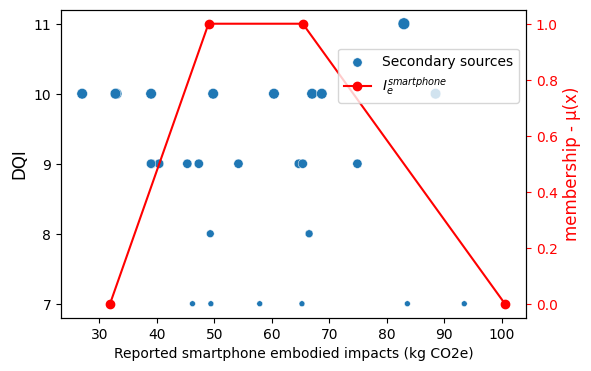

In [10]:
arbitrary_points_x = [L, ml, mr, R]
arbitrary_points_y = [0, 1, 1, 0]


fig, ax1 = plt.subplots(1, 1, figsize=(6, 4))

sns.scatterplot(
    x="value", y="dqi", data=data, size="dqi", label="Secondary sources", legend=False
)

# plt.title('Distribution of estimated smartphone pre-use impact')
plt.xlabel(
    "Reported smartphone embodied impacts (kg CO2e)"
)  # Replace with an appropriate label
plt.ylabel("DQI", fontsize=12)  # Replace with an appropriate label

ax2 = ax1.twinx()

ax2.plot(
    arbitrary_points_x,
    arbitrary_points_y,
    color="red",
    marker="o",
    label=r"$I_{e}^{smartphone}$",
)

ax2.set_ylabel("membership - μ(x)", color="red", fontsize=12)
# ax2.set_ylabel('μ(x)', color='red',fontsize=14)
ax2.tick_params(axis="y", colors="red")

# yint = range(min(data['dqi']), math.ceil(max(data['dqi']))+2)

# ax1.set_yticks(yint)
ax1.yaxis.get_major_locator().set_params(integer=True)

fig.legend(loc="upper right", bbox_to_anchor=(-0.1, -0.2, 1, 1))

# fig.legend()
# plt.show()
plt.gcf().savefig("figures/fuzzy.pdf", bbox_inches="tight")

# Arithmetics


## Test relative for multiplication


In [11]:
A = Fuzzy(0, 1, 3, 4)
B = Fuzzy(0, 10, 14, 20)
C = Fuzzy(0, 10, 42, 80)

A_fixed = Fuzzy(A.defuzzy(), A.defuzzy(), A.defuzzy(), A.defuzzy())
B_fixed = Fuzzy(B.defuzzy(), B.defuzzy(), B.defuzzy(), B.defuzzy())

share_A = A.multiply_by(B_fixed).high_uncertainty()
share_B = B.multiply_by(A_fixed).high_uncertainty()

print(share_A)
print(share_B)
print(C.high_uncertainty())
print()

12.0
4.0
16.0



## Test relative for division


In [12]:
A = Fuzzy(1, 10, 14, 20)
B = Fuzzy(1, 2, 4, 10)
C = A.divide_by(B)

A_fixed = Fuzzy(A.defuzzy(), A.defuzzy(), A.defuzzy(), A.defuzzy())
B_fixed = Fuzzy(B.defuzzy(), B.defuzzy(), B.defuzzy(), B.defuzzy())

print(A.divide_by(B_fixed).high_uncertainty())
print(A_fixed.divide_by(B).high_uncertainty())
print(C.high_uncertainty())

0.666666666666667
1.5
2.25


## Linearity


ON NE PEUT PAS UTILISER LE QUADRATIQUE EN LOGIQUE FLOUE


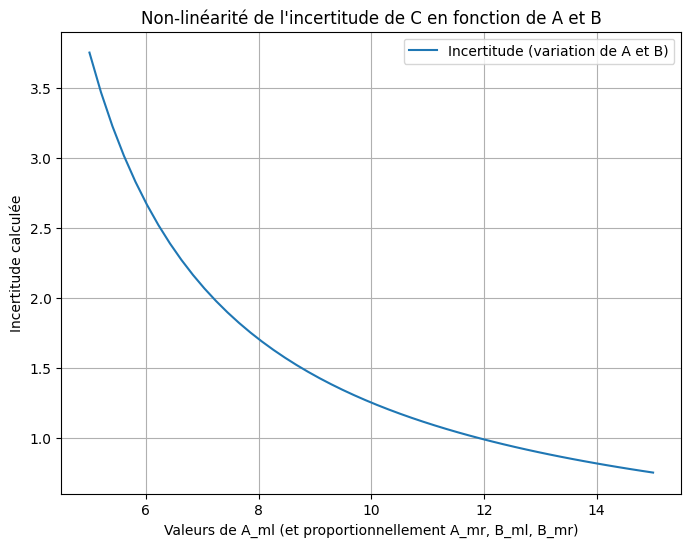

In [13]:
import matplotlib.pyplot as plt


# Fonction pour calculer l'incertitude selon la formule donnée
def calculate_uncertainty(A_ml, A_mr, B_ml, B_mr):
    C_mr = A_mr / B_ml
    C_ml = A_ml / B_mr
    return C_mr - (C_ml + C_mr) / 2


# Variation des valeurs de A et B
A_ml_values = np.linspace(5, 15, 50)  # Borne inférieure de A varie de 5 à 15
A_mr_values = np.linspace(10, 20, 50)  # Borne supérieure de A varie de 10 à 20
B_ml_values = np.linspace(1, 5, 50)  # Borne inférieure de B varie de 1 à 5
B_mr_values = np.linspace(2, 6, 50)  # Borne supérieure de B varie de 2 à 6

# Stocker les incertitudes calculées
uncertainties = []

# Calcul de l'incertitude pour différentes combinaisons de A et B
for A_ml, A_mr, B_ml, B_mr in zip(A_ml_values, A_mr_values, B_ml_values, B_mr_values):
    uncert = calculate_uncertainty(A_ml, A_mr, B_ml, B_mr)
    uncertainties.append(uncert)

# Visualisation des résultats
plt.figure(figsize=(8, 6))
plt.plot(A_ml_values, uncertainties, label="Incertitude (variation de A et B)")
plt.xlabel("Valeurs de A_ml (et proportionnellement A_mr, B_ml, B_mr)")
plt.ylabel("Incertitude calculée")
plt.title("Non-linéarité de l'incertitude de C en fonction de A et B")
plt.legend()
plt.grid(True)
plt.show()

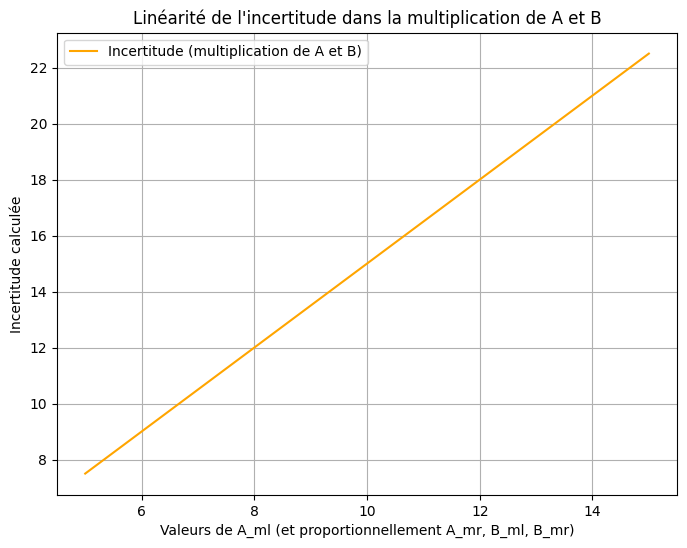

In [14]:
# Fonction pour calculer l'incertitude pour une multiplication
def calculate_multiplication_uncertainty(A_ml, A_mr, B_ml, B_mr):
    C_mr = A_mr * B_mr
    C_ml = A_ml * B_ml
    return C_mr - (C_ml + C_mr) / 2


# Stocker les incertitudes calculées pour la multiplication
multiplication_uncertainties = []

# Calcul de l'incertitude pour la multiplication avec différentes combinaisons de A et B
for A_ml, A_mr, B_ml, B_mr in zip(A_ml_values, A_mr_values, B_ml_values, B_mr_values):
    uncert_mult = calculate_multiplication_uncertainty(A_ml, A_mr, B_ml, B_mr)
    multiplication_uncertainties.append(uncert_mult)

# Visualisation des résultats pour la multiplication
plt.figure(figsize=(8, 6))
plt.plot(
    A_ml_values,
    multiplication_uncertainties,
    label="Incertitude (multiplication de A et B)",
    color="orange",
)
plt.xlabel("Valeurs de A_ml (et proportionnellement A_mr, B_ml, B_mr)")
plt.ylabel("Incertitude calculée")
plt.title("Linéarité de l'incertitude dans la multiplication de A et B")
plt.legend()
plt.grid(True)
plt.show()

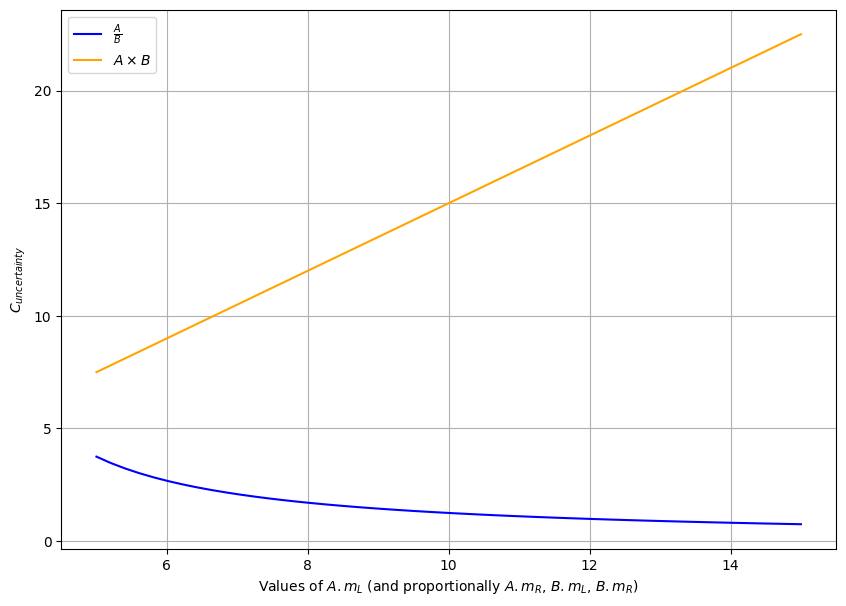

In [15]:
# Création de la figure avec deux tracés pour la multiplication et la division sur le même graphique
plt.figure(figsize=(10, 7))

# Tracé de l'incertitude pour la division
plt.plot(A_ml_values, uncertainties, label=r"$\frac{A}{B}$", color="blue")

# Tracé de l'incertitude pour la multiplication
plt.plot(
    A_ml_values,
    multiplication_uncertainties,
    label=r"$A \times B$",
    color="orange",
)

# Configuration des axes et du titre
plt.xlabel(
    "Values of "
    + r"$A.m_L$"
    + " (and proportionally "
    + r"$A.m_R$"
    + ", "
    + r"$B.m_L$"
    + ", "
    + r"$B.m_R$"
    + ")"
)
plt.ylabel(r"$C_{uncertainty}$")
# plt.title("Comparison of uncertainties in the multiplication and division of A and B")

# Ajout de la légende et de la grille
plt.legend()
plt.grid(True)

# Affichage de la figure
# plt.show()

plt.gcf().savefig("figures/mult_div_fuzzy.pdf", bbox_inches="tight")

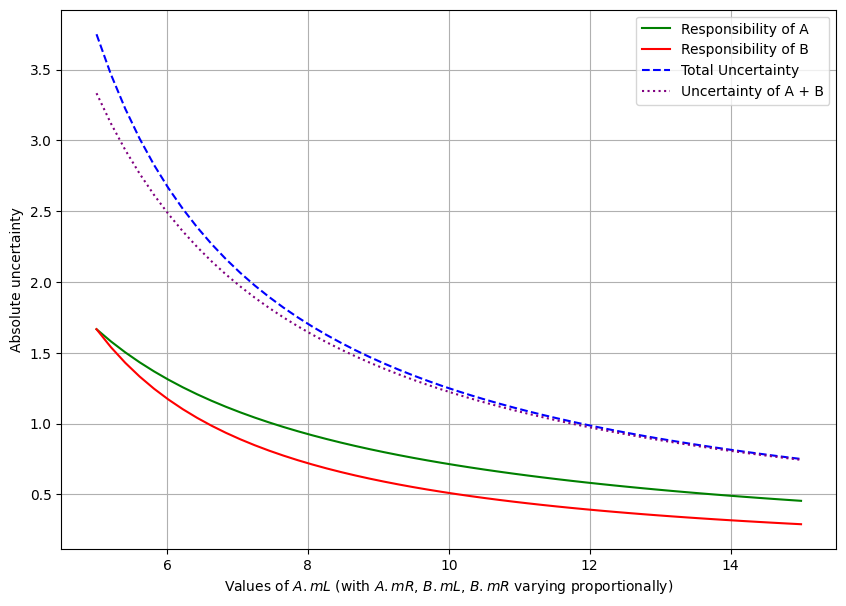

In [16]:
# Updated code with English labels for the graph

import numpy as np
import matplotlib.pyplot as plt


# Function to calculate uncertainty for division
def calculate_uncertainty(A_ml, A_mr, B_ml, B_mr):
    C_mr = A_mr / B_ml
    C_ml = A_ml / B_mr
    return C_mr - (C_ml + C_mr) / 2


# Function to calculate A's responsibility in division
def responsibility_A(A_ml, A_mr, B_ml, B_mr):
    A_c = (A_ml + A_mr) / 2
    B_c = (B_ml + B_mr) / 2
    C_c = A_c / B_c
    delta_A = A_mr - A_c
    return C_c * (delta_A / A_c)


# Function to calculate B's responsibility in division
def responsibility_B(A_ml, A_mr, B_ml, B_mr):
    A_c = (A_ml + A_mr) / 2
    B_c = (B_ml + B_mr) / 2
    C_c = A_c / B_c
    delta_B = B_mr - B_c
    return C_c * (delta_B / B_c)


# Varying values for A and B
A_ml_values = np.linspace(5, 15, 50)  # Lower bound of A varies from 5 to 15
A_mr_values = np.linspace(10, 20, 50)  # Upper bound of A varies from 10 to 20
B_ml_values = np.linspace(1, 5, 50)  # Lower bound of B varies from 1 to 5
B_mr_values = np.linspace(2, 6, 50)  # Upper bound of B varies from 2 to 6

# Store calculated uncertainties for division
total_uncertainties = []
responsibility_A_values = []
responsibility_B_values = []

# Calculate uncertainties and responsibilities for division
for A_ml, A_mr, B_ml, B_mr in zip(A_ml_values, A_mr_values, B_ml_values, B_mr_values):
    uncert_total = calculate_uncertainty(A_ml, A_mr, B_ml, B_mr)
    total_uncertainties.append(uncert_total)

    resp_A = responsibility_A(A_ml, A_mr, B_ml, B_mr)
    resp_B = responsibility_B(A_ml, A_mr, B_ml, B_mr)

    responsibility_A_values.append(resp_A)
    responsibility_B_values.append(resp_B)

# Calculate the sum of responsibilities for A and B
responsibility_sum = np.array(responsibility_A_values) + np.array(
    responsibility_B_values
)

# Plot responsibilities of A, B, their sum, and total uncertainty in the division
plt.figure(figsize=(10, 7))

# Plot A's responsibility in the division
plt.plot(
    A_ml_values,
    responsibility_A_values,
    label="Responsibility of A",
    color="green",
)

# Plot B's responsibility in the division
plt.plot(
    A_ml_values,
    responsibility_B_values,
    label="Responsibility of B",
    color="red",
)

# Plot total uncertainty in the division
plt.plot(
    A_ml_values,
    total_uncertainties,
    label="Total Uncertainty",
    color="blue",
    linestyle="--",
)

# Plot sum of responsibilities of A and B in the division
plt.plot(
    A_ml_values,
    responsibility_sum,
    label="Uncertainty of A + B",
    color="purple",
    linestyle=":",
)

# Set axes labels and title
plt.xlabel(
    "Values of "
    + r"$A.mL$"
    + " (with "
    + r"$A.mR$"
    + ", "
    + r"$B.mL$"
    + ", "
    + r"$B.mR$"
    + " varying proportionally)"
)
plt.ylabel("Absolute uncertainty")
# plt.title("Comparison of A, B Responsibilities and Total Uncertainty in C (Division)")

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.gcf().savefig("figures/div_fuzzy.pdf", bbox_inches="tight")

## Check variations of A and B in multiplications and divisions


In [17]:
for i in range(10000):
    a = random.randint(100, 500)
    b = random.randint(500, 1000)
    c = random.randint(1100, 2000)
    d = random.randint(2000, 3000)

    A = Fuzzy(0, a, b, b + 3)
    B = Fuzzy(0, c, d, d + 5413)
    C = A.multiply_by(B)

    A_fixed = Fuzzy(A.defuzzy(), A.defuzzy(), A.defuzzy(), A.defuzzy())
    B_fixed = Fuzzy(B.defuzzy(), B.defuzzy(), B.defuzzy(), B.defuzzy())

    uncertainty_a = A.multiply_by(B_fixed).high_uncertainty()
    uncertainty_b = B.multiply_by(A_fixed).high_uncertainty()

    uncertainty_tot = uncertainty_a + uncertainty_b
    if uncertainty_tot != C.high_uncertainty():
        print("NO")

In [18]:
import random

for i in range(10000):
    a = random.randint(100, 500)
    b = random.randint(500, 1000)
    c = random.randint(1100, 2000)
    d = random.randint(2000, 3000)

    A = Fuzzy(1, a, b, b + 3)
    B = Fuzzy(1, c, d, d + 5413)
    C = A.divide_by(B)

    A_fixed = Fuzzy(A.defuzzy(), A.defuzzy(), A.defuzzy(), A.defuzzy())
    B_fixed = Fuzzy(B.defuzzy(), B.defuzzy(), B.defuzzy(), B.defuzzy())

    uncertainty_a = A.divide_by(B_fixed).high_uncertainty()
    uncertainty_b = A_fixed.divide_by(B).high_uncertainty()

    uncertainty_tot = uncertainty_a + uncertainty_b

    if uncertainty_tot > C.high_uncertainty():
        print(uncertainty_a)
        print(uncertainty_b)
        print("-------")
        print(uncertainty_tot)
        print(C.high_uncertainty())
        print()
        print()

# Never above

# Allocation choices


In [19]:
del C

## Calculation


In [20]:
gspt_fuzzys = pd.read_csv("data/gspt_fuzzys.csv")
gspt_fuzzys = gspt_fuzzys.set_index("Variable")

gspt_fuzzys["low"] = gspt_fuzzys.apply(
    lambda row: Fuzzy(
        L=row["L"], ml=row["ml"], mr=row["mr"], R=row["R"]
    ).low_uncertainty(),
    axis=1,
)
gspt_fuzzys["defuzzy"] = gspt_fuzzys.apply(
    lambda row: Fuzzy(L=row["L"], ml=row["ml"], mr=row["mr"], R=row["R"]).defuzzy(),
    axis=1,
)
gspt_fuzzys["high"] = gspt_fuzzys.apply(
    lambda row: Fuzzy(
        L=row["L"], ml=row["ml"], mr=row["mr"], R=row["R"]
    ).high_uncertainty(),
    axis=1,
)
gspt_fuzzys

,Label,Name,L,ml,mr,R,Unit,low,defuzzy,high
Variable,,,,,,,,,,
Iem,$F_{em}$,Electricity mix,0.297775,0.557436,0.911557,1.706440,kgCO2e,0.177060,0.734496,0.177060
ied,$I_{e}^{device}$,Device and battery embodied impact,31.412558,48.753701,65.615186,101.837715,kg CO2e,8.430743,57.184444,8.430743
ieb,$I_{e}^{bat.}$,Battery embodied impact,0.723200,1.166300,1.626300,2.622600,kg CO2e,0.230000,1.396300,0.230000
cmax,$C_{max}$,Maximum battery cycles,328.720505,500.069021,661.158732,1005.793661,NaN,80.544856,580.613877,80.544856
V,$V$,Battery Voltage,3.789900,3.808500,3.817900,3.836600,V,0.004700,3.813200,0.004700
bcap,$B_{cap}$,Battery capacity,1.727551,2.618037,3.449889,5.228173,Ah,0.415926,3.033963,0.415926
C_eff,$C_{eff}$,Charger efficiency,59.038467,68.603889,74.518370,86.591849,NaN,2.957240,71.561130,2.957240
R,$R$,Battery to device replacement ratio,0.089186,0.170800,0.287163,0.549948,NaN,0.058181,0.228982,0.058181
rmax,$\overline{R}$,Avg. batteries replacements,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,1.000000,0.000000


In [21]:
print(
    gspt_fuzzys[["Label", "Name", "Unit", "L", "ml", "mr", "R"]].to_latex(index=False)
)

\begin{tabular}{lllrrrr}
\toprule
Label & Name & Unit & L & ml & mr & R \\
\midrule
$F_{em}$ & Electricity mix & kgCO2e & 0.297775 & 0.557436 & 0.911557 & 1.706440 \\
$I_{e}^{device}$ & Device and battery embodied impact & kg CO2e & 31.412558 & 48.753701 & 65.615186 & 101.837715 \\
$I_{e}^{bat.}$ & Battery embodied impact & kg CO2e & 0.723200 & 1.166300 & 1.626300 & 2.622600 \\
$C_{max}$ & Maximum battery cycles & NaN & 328.720505 & 500.069021 & 661.158732 & 1005.793661 \\
$V$ & Battery Voltage & V & 3.789900 & 3.808500 & 3.817900 & 3.836600 \\
$B_{cap}$ & Battery capacity & Ah & 1.727551 & 2.618037 & 3.449889 & 5.228173 \\
$C_{eff}$ & Charger efficiency & NaN & 59.038467 & 68.603889 & 74.518370 & 86.591849 \\
$R$ & Battery to device replacement ratio & NaN & 0.089186 & 0.170800 & 0.287163 & 0.549948 \\
$\overline{R}$ & Avg. batteries replacements & NaN & 1.000000 & 1.000000 & 1.000000 & 1.000000 \\
$S$ & Share of users & NaN & 100.000000 & 100.000000 & 100.000000 & 100.000000 \\
\bott

In [22]:
iem_row = gspt_fuzzys.loc["Iem"]
iem = Fuzzy(L=iem_row["L"], ml=iem_row["ml"], mr=iem_row["mr"], R=iem_row["R"])
absolute_iem = iem.defuzzy()

# ied_row = gspt_fuzzys.loc["ied"]
# ied = Fuzzy(L=ied_row["L"], ml=ied_row["ml"], mr=ied_row["mr"], R=ied_row["R"])
ied = Fuzzy(L=L, ml=ml, mr=mr, R=R)
absolute_ied = ied.defuzzy()

ieb_row = gspt_fuzzys.loc["ieb"]
ieb = Fuzzy(L=ieb_row["L"], ml=ieb_row["ml"], mr=ieb_row["mr"], R=ieb_row["R"])
absolute_ieb = ieb.defuzzy()

cmax_row = gspt_fuzzys.loc["cmax"]
cmax = Fuzzy(L=cmax_row["L"], ml=cmax_row["ml"], mr=cmax_row["mr"], R=cmax_row["R"])
absolute_cmax = cmax.defuzzy()


V_row = gspt_fuzzys.loc["V"]
V = Fuzzy(L=V_row["L"], ml=V_row["ml"], mr=V_row["mr"], R=V_row["R"])
absolute_V = V.defuzzy()

bcap_row = gspt_fuzzys.loc["bcap"]
bcap = Fuzzy(L=bcap_row["L"], ml=bcap_row["ml"], mr=bcap_row["mr"], R=bcap_row["R"])
absolute_bcap = bcap.defuzzy()

C_eff_row = gspt_fuzzys.loc["C_eff"]
C_eff = Fuzzy(L=C_eff_row["L"], ml=C_eff_row["ml"], mr=C_eff_row["mr"], R=C_eff_row["R"])
absolute_C = C_eff.defuzzy()

R_row = gspt_fuzzys.loc["R"]
R = Fuzzy(L=R_row["L"], ml=R_row["ml"], mr=R_row["mr"], R=R_row["R"])
absolute_R = R.defuzzy()


rmax_row = gspt_fuzzys.loc["rmax"]
rmax = Fuzzy(L=rmax_row["L"], ml=rmax_row["ml"], mr=rmax_row["mr"], R=rmax_row["R"])
absolute_rmax = rmax.defuzzy()

$$F_{e}^{bat.} = \frac{R \times(I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{1 + \overline{R}}) + (1-R) \times I_{e}^{device}}{C_{max} \times B_{cap}}$$


$$B_{total} = C_{max} \times B_{cap}$$


In [23]:
b_total = cmax.multiply_by(bcap)

cmax_relative, bcap_relative = relative_multiplication(b_total, cmax, bcap)

$$(1-R) \times I_{e}^{device}$$


In [24]:
p_no_replace = Fuzzy(1, 1, 1, 1).substract(R).reverse()
i_no_replace = p_no_replace.multiply_by(ied)

R_no_replace_relative, one_no_replace_relative = relative_substraction(
    p_no_replace, R, Fuzzy(1, 1, 1, 1)
)
p_no_replace_relative, ied_no_replace_relative = relative_multiplication(
    i_no_replace, p_no_replace, ied
)

NOK sub
0.05818135199999999
0.058181352000000075
Comparison of relative sum vs total
0.058181352000000075
0.05818135199999999


$$R \times(I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{1 + \overline{R}})$$


In [25]:
device_witout_batt = ied.substract(ieb)
number_batter_replacements = Fuzzy(1, 1, 1, 1).add(rmax)
device_per_battery_replaced = device_witout_batt.divide_by(number_batter_replacements)

ied_replaced_sub_relative, ieb_replaced_sub_relative = relative_substraction(
    device_witout_batt, ied, ieb
)

_, device_witout_batt_relative, number_batter_replacements_relative = relative_fraction(
    device_per_battery_replaced, device_witout_batt, number_batter_replacements
)

ied_replaced = ieb.add(device_per_battery_replaced)
i_replace = R.multiply_by(ied_replaced)

ieb_relative, device_per_battery_replaced_relative = relative_addition(
    ied_replaced, ieb, device_per_battery_replaced
)
R_relative, ied_replaced_relative = relative_multiplication(i_replace, R, ied_replaced)

NOK sub
8.432200675076697
7.972200675076692
Comparison of relative sum vs total
7.972200675076692
7.972200675076696
NOK add
4.216100337538347
4.21610033753835
NOK mult
2.6697431937044103
2.669743193704411


$$F_{e}^{bat.} = \frac{R \times(I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{1 + \overline{R}}) + (1-R) \times I_{e}^{device}}{B_{total}}$$


In [26]:
embodied_num = i_replace.add(i_no_replace)
embodied = embodied_num.divide_by(b_total)

i_replace_relative, i_no_replace_relative = relative_addition(
    embodied_num, i_replace, i_no_replace
)
_, embodied_num_relative, b_total_relative = relative_fraction(
    embodied, embodied_num, b_total
)

NOK add
12.321219615213634
12.321219615213636
NOK div
0.01524728846840856
0.015789894753369157


$$F_{u}^{bat.} = \frac{V \times F_{em}}{C_{eff}}$$


In [27]:
usage_num = V.multiply_by(iem)
usage = usage_num.divide_by(C_eff)

V_relative, iem_relative = relative_multiplication(usage_num, V, iem)
_, usage_num_relative, C_eff_relative = relative_fraction(usage, usage_num, C_eff)

NOK div
0.011103680049566099
0.011119902234709524


$$F^{device} = F_{e(d)}^{bat.} + F_{u(d)}^{bat.}$$


In [28]:
total_device = embodied.add(usage)
relative_embodied, relative_usage = relative_addition(total_device, embodied, usage)

NOK add
0.02690979698807868
0.026909796988078688


## Tree


In [29]:
uncertainties_tree = {
    "total_device": {
        "value": str(round(total_device.high_uncertainty(), 4)),
        "label": "$F^{device}$",
        "sources": {
            "usage": {
                "value": relative_usage,
                "label": r"$\frac{V \times F_{em}}{C}$",
                "sources": {
                    "du_num": {
                        "value": usage_num_relative,
                        "label": r"$V \times F_{em}$",
                        "sources": {
                            "iem_relative": {
                                "value": iem_relative,
                                "label": r"$F_{em}$",
                                "sources": {},
                            },
                            "V_relative": {
                                "value": V_relative,
                                "label": r"$V$",
                                "sources": {},
                            },
                        },
                    },
                    "C": {
                        "value": C_eff_relative,
                        "label": r"$C_{eff}$",
                        "sources": {},
                    },
                },
            },
            "embodied": {
                "value": relative_embodied,
                "label": r"$\frac{R \times(I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{1 + \overline{R}}) + (1-R) \times I_{e}^{device}}{C_{max} \times B_{cap}}$",
                "sources": {
                    "embodied_num": {
                        "value": embodied_num_relative,
                        "label": r"$R \times(I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{1 + \overline{R}}) + (1-R) \times I_{e}^{device}$",
                        "sources": {
                            "i_replace": {
                                "value": i_replace_relative,
                                "label": r"$R \times(I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{ w\overline{R}})$",
                                "sources": {
                                    "ied_replaced": {
                                        "value": ied_replaced_relative,
                                        "label": r"$I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{ \overline{R}}$",
                                        "sources": {
                                            "fraction": {
                                                "value": device_per_battery_replaced_relative,
                                                "label": r"$\frac{I_{e}^{device}-I_{e}^{bat.}}{ \overline{R}}$",
                                                "sources": {
                                                    "device_witout_batt": {
                                                        "value": device_witout_batt_relative,
                                                        "label": r"$I_{e}^{device}-I_{e}^{bat.}$",
                                                        "sources": {
                                                            "ied": {
                                                                "value": ied_replaced_sub_relative,
                                                                "label": r"$I_{e}^{device}$",
                                                                "sources": {},
                                                            },
                                                            "ieb": {
                                                                "value": ieb_replaced_sub_relative,
                                                                "label": r"$I_{e}^{bat.}$",
                                                                "sources": {},
                                                            },
                                                        },
                                                    },
                                                    "number_batter_replacements": {
                                                        "value": number_batter_replacements_relative,
                                                        "label": r"1+$\overline{R}$",
                                                        "sources": {},
                                                    },
                                                },
                                            },
                                            "ieb": {
                                                "value": ieb_relative,
                                                "label": r"$I_{e}^{bat.}$",
                                                "sources": {},
                                            },
                                        },
                                    },
                                    "R": {
                                        "label": r"$R$",
                                        "value": R_relative,
                                        "sources": {},
                                    },
                                },
                            },
                            "i_no_replace": {
                                "value": i_no_replace_relative,
                                "label": r"$(1-R) \times I_{e}^{device}$",
                                "sources": {
                                    "r_inverse": {
                                        "value": p_no_replace_relative,
                                        "label": r"$(1-R)$",
                                        "sources": {
                                            "one": {
                                                "value": one_no_replace_relative,
                                                "label": r"$1$",
                                                "sources": {},
                                            },
                                            "R": {
                                                "value": R_no_replace_relative,
                                                "label": r"$R$",
                                                "sources": {},
                                            },
                                        },
                                    },
                                    "ied": {
                                        "value": ied_no_replace_relative,
                                        "label": r"$I_{e}^{device}$",
                                        "sources": {},
                                    },
                                },
                            },
                        },
                    },
                    "b_total": {
                        "value": b_total_relative,
                        "label": r"$C_{max} \times B_{cap}$",
                        "sources": {
                            "cmax_relative": {
                                "value": cmax_relative,
                                "label": r"$C_{max}$",
                                "sources": {},
                            },
                            "bcap_relative": {
                                "value": bcap_relative,
                                "label": r"$B_{cap}$",
                                "sources": {},
                            },
                        },
                    },
                },
            },
        },
    }
}

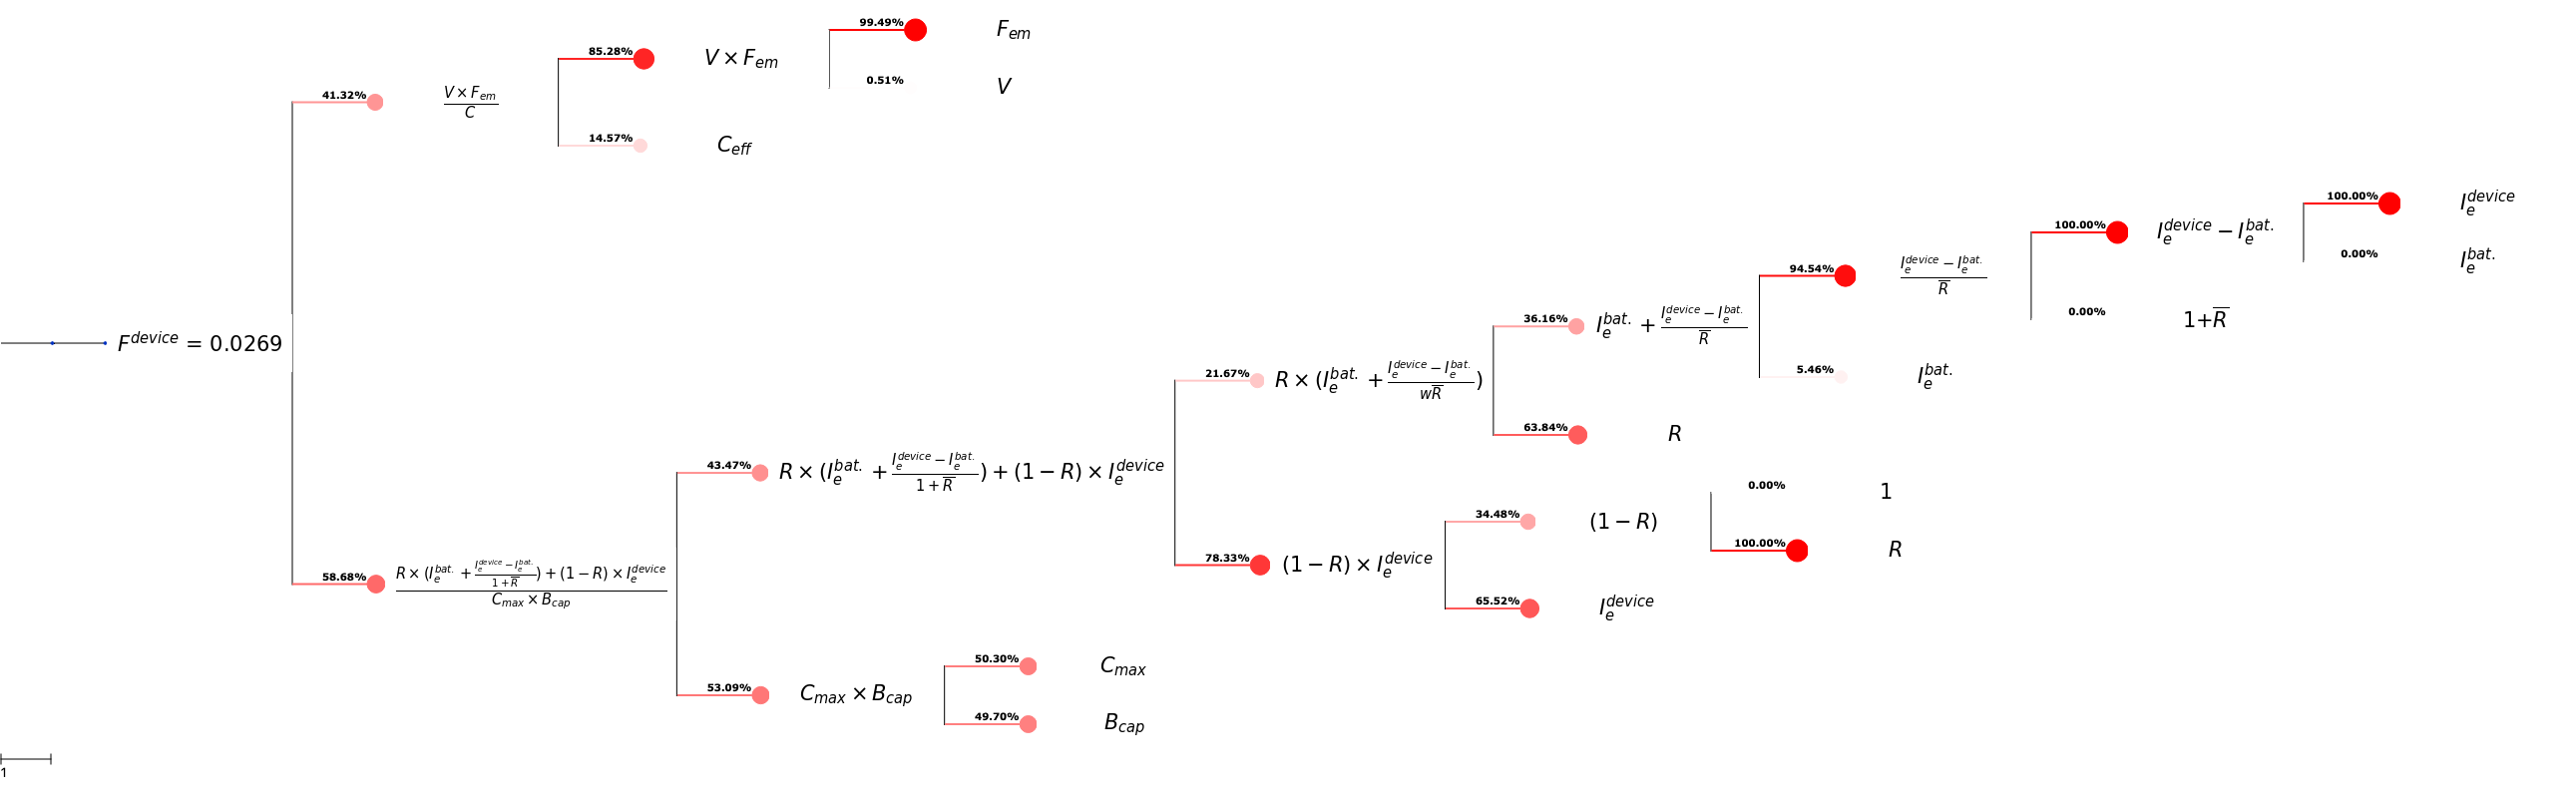

In [30]:
def draw_tree(dictionary, root_node_name):
    # Function to generate an image from LaTeX and save it to a temporary file
    def latex_to_image(latex, fontsize=15):
        fig, ax = plt.subplots(figsize=(2, 0.5))
        ax.text(0.5, 0.5, f"{latex}", fontsize=fontsize, va="center", ha="center")
        ax.set_axis_off()

        # Save image to a temporary file
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
        plt.savefig(temp_file.name, format="png", bbox_inches="tight", pad_inches=0.1)
        temp_file.close()
        plt.close(fig)

        return temp_file.name

    # Function to add the LaTeX-rendered image to the node using node.add_face()
    def add_latex_face(node, latex, column=0):
        img_path = latex_to_image(latex)
        face = faces.ImgFace(img_path)
        node.add_face(face, column)

    # Function to interpolate colors between white (low) and red (high) for smooth transitions
    def interpolate_color(
        value,
        min_value=0,
        max_value=100,
        start_color=(255, 255, 255),
        end_color=(255, 0, 0),
    ):
        norm_value = (value - min_value) / (max_value - min_value)
        norm_value = min(max(norm_value, 0), 1)  # Clamp the value between 0 and 1

        # Interpolate between the RGB values of the start and end colors
        red = int(start_color[0] + (end_color[0] - start_color[0]) * norm_value)
        green = int(start_color[1] + (end_color[1] - start_color[1]) * norm_value)
        blue = int(start_color[2] + (end_color[2] - start_color[2]) * norm_value)

        return f"#{red:02x}{green:02x}{blue:02x}"

    # Updated get_color function to use interpolation
    def get_color(value):
        return interpolate_color(value, 0, 100, (255, 255, 255), (255, 0, 0))

    # Function to apply node style based on percentage
    def apply_node_style(node, value):
        nstyle = NodeStyle()
        nstyle["fgcolor"] = get_color(value)  # "black"  # Node color
        nstyle["size"] = 12 + (value / 10)  # Adjust node size based on value
        # nstyle["bgcolor"] = get_color(value)  # Set background color
        nstyle["shape"] = "circle"  # Node shape
        node.set_style(nstyle)

    # Function to apply link style based on percentage
    def apply_link_style(node, value):
        nstyle = node._get_style()  # Get the current NodeStyle object
        link_color = get_color(value)  # Get color based on the value

        # Set horizontal and vertical link colors (lines leading to the node)
        nstyle["hz_line_color"] = link_color
        # nstyle["vt_line_color"] = link_color
        nstyle["hz_line_width"] = 2  # Adjust link width (optional)
        nstyle["vt_line_width"] = 1  # Adjust link width (optional)
        node.set_style(nstyle)

    # Function to add the value under the horizontal line of the node
    def add_value_below_branch(node, value):
        value_face = faces.TextFace(
            f"{value:.2f}%", fgcolor="black", fsize=10, bold=True
        )
        node.add_face(value_face, column=0, position="branch-top")
        node.dist = node.dist * 1.5  # Increase the branch length by 50%

    # Recursive function to build the tree
    def build_tree(t, data, parent_name):
        for key, value in data.items():
            if isinstance(value, dict):
                latex_label = value.get(
                    "label", ""
                )  # Use only the LaTeX label as node name
                node_value = value.get("value", 0)

                child = t.add_child()
                # To generate the latex formula as an image
                add_latex_face(child, latex_label)
                # Apply color based on value
                apply_node_style(child, value.get("value", 0))
                apply_link_style(child, value.get("value", 0))

                # Display percentage uner branch
                add_value_below_branch(
                    child, node_value
                )  # Display the value below the horizontal line

                build_tree(child, value.get("sources", {}), latex_label)
            else:
                raise Exception("Value is not a dict" + str(value))

    # Create the root of the tree
    t = Tree()
    root = t.add_child()

    # Add LaTeX label to the root
    add_latex_face(
        root,
        f"{dictionary[root_node_name]['label']} = {dictionary[root_node_name]['value']}",
    )

    # Build the tree recursively
    build_tree(root, dictionary[root_node_name]["sources"], root_node_name)

    # Set up tree style
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.scale = 50  # Zoom in horizontally for better node spacing
    # ts.branch_vertical_margin = 15  # Increase vertical space between nodes

    # Change branch length scale (zoom in X)
    # ts.scale = 120  # 120 pixels per branch length unit

    # Change branch separation between nodes (zoom in Y)
    # ts.branch_vertical_margin = 2  # 10 pixels between adjacent branches

    # circular tree in 180 degrees
    # ts.mode = "c"
    # ts.arc_start = 100  # 0 degrees = 3 o'clock
    # ts.arc_span = 100

    return t, ts


t, ts = draw_tree(uncertainties_tree, "total_device")
t.render("figures/uncertainty_tree.pdf", tree_style=ts)
t.render("%%inline", tree_style=ts)

## Checks


In [31]:
# Check that sum of all sources is 100
def check_sources_sum_100(tree):
    sum_childs = 0
    for child in tree["sources"]:
        sum_childs += tree["sources"][child]["value"]
        # Recursive call
        check_sources_sum_100(tree["sources"][child])

    if sum_childs != 0 and sum_childs != 100:
        print(sum_childs)
        print(tree["label"])


check_sources_sum_100(uncertainties_tree["total_device"])

99.85
$\frac{V \times F_{em}}{C}$
96.56
$\frac{R \times(I_{e}^{bat.} + \frac{I_{e}^{device}-I_{e}^{bat.}}{1 + \overline{R}}) + (1-R) \times I_{e}^{device}}{C_{max} \times B_{cap}}$


In [32]:
# Find the relative contribution of each individual variable
individual_values = {}


def find_variable_share(dictionary: dict, father_value: float):
    self_absolute = float(father_value) * (float(dictionary["value"]) / float(100))

    # Add only if it is a tree leaf
    if not dictionary["sources"]:
        if dictionary["label"] in individual_values:
            individual_values[dictionary["label"]] += self_absolute
        else:
            individual_values[dictionary["label"]] = self_absolute
    else:
        for child in dictionary["sources"]:
            find_variable_share(
                dictionary=dictionary["sources"][child], father_value=self_absolute
            )


find_variable_share(
    dictionary=uncertainties_tree["total_device"],
    father_value=uncertainties_tree["total_device"]["value"],
)
individual_values

{'$F_{em}$': 2.536830762162694e-06,
 '$V$': 1.30041580933056e-08,
 '$C_{eff}$': 4.356366649639999e-07,
 '$I_{e}^{device}$': 1.0840347206256216e-06,
 '$I_{e}^{bat.}$': 7.897038970671918e-09,
 '1+$\\overline{R}$': 0.0,
 '$R$': 7.538668111597062e-07,
 '$1$': 0.0,
 '$C_{max}$': 1.133901619486596e-06,
 '$B_{cap}$': 1.120375954045404e-06}

In [33]:
# Filter the dictionary to only include values greater than 0
filtered_data = {
    k: v
    for k, v in sorted(
        individual_values.items(), key=lambda item: item[1], reverse=True
    )
    if v > 0  # Only include values greater than 0
}

# Calculating the total to convert values into percentages
total_value = sum(filtered_data.values())

# Converting each value to a percentage
filtered_data_percentage = {
    key: (value / total_value) * 100 for key, value in filtered_data.items()
}
filtered_data_percentage

data = {
    "originals": {
        "$F_{em}$": iem.uncertainty_per(),
        "$C_{max}$": cmax.uncertainty_per(),
        "$B_{cap}$": bcap.uncertainty_per(),
        "$I_{e}^{device}$": ied.uncertainty_per(),
        "$R$": R.uncertainty_per(),
        "$C_{eff}$": C_eff.uncertainty_per(),
        "$V$": V.uncertainty_per(),
        "$I_{e}^{bat.}$": ieb.uncertainty_per(),
    },
    "updated": filtered_data_percentage,
}
data

{'originals': {'$F_{em}$': np.float64(24.10633578457492),
  '$C_{max}$': np.float64(13.872361441776794),
  '$B_{cap}$': np.float64(13.709008661805145),
  '$I_{e}^{device}$': np.float64(14.341858028740528),
  '$R$': np.float64(25.408744285583698),
  '$C_{eff}$': np.float64(4.132467271729604),
  '$V$': np.float64(0.12325605790412641),
  '$I_{e}^{bat.}$': np.float64(16.472104848528268)},
 'updated': {'$F_{em}$': 35.802888626351034,
  '$C_{max}$': 16.003019989046503,
  '$B_{cap}$': 15.812129094544957,
  '$I_{e}^{device}$': 15.299236728180135,
  '$R$': 10.639499442226644,
  '$C_{eff}$': 6.148242614325728,
  '$V$': 0.18353073876207693,
  '$I_{e}^{bat.}$': 0.11145276656290715}}

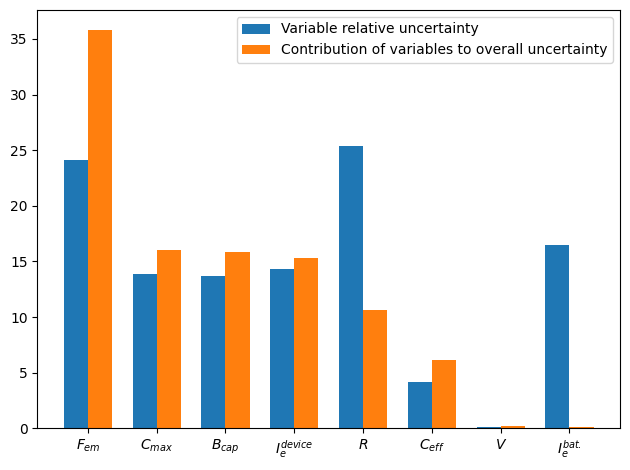

In [34]:
# Labels and values
labels = list(data["originals"].keys())  # Ensuring the order of labels
original_values = [data["originals"][key] for key in labels]
updated_values = [data["updated"][key] for key in labels]
# Plotting side-by-side bar chart
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots()
rects1 = ax.bar(
    x - width / 2, original_values, width, label="Variable relative uncertainty"
)
rects2 = ax.bar(
    x + width / 2,
    updated_values,
    width,
    label="Contribution of variables to overall uncertainty",
)

# Adding labels, title, and custom ticks
# ax.set_xlabel("Parameters")
# ax.set_title("Comparison of Original and Updated Values ordered by Contribution")
ax.set_xticks(x)
ax.set_xticklabels(labels, ha="center")
ax.legend()

# Show plot
plt.tight_layout()
plt.gcf().savefig("figures/uncertainty_share.pdf", bbox_inches="tight")